In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Custom architecture

Loading a custum architecture is easy with ``AUCMEDI``.  
[Here](https://frankkramer-lab.github.io/aucmedi/reference/neural_network/architectures/image/#aucmedi.neural_network.architectures.image) is a list of the image-architetures that can be loaded with aucmedi.
We will choose ``ResNet50``.

But fist, the data need to be loaded.

## Downloading and preparing the data

First, the data need to be loaded and prepared for ``AUCMEDI``.  
If you have questions concering that part, just have a look in the corresponding notebook.

In [2]:
from pathlib import Path
import wget
import zipfile

cwd = !pwd
datadir = cwd[0] + "/data"
Path(datadir).mkdir(parents=True, exist_ok=True)

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], 
                                         stratified=True, iterative=False, seed=123)

2022-07-19 13:13:58.745522: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Define the model

The easiest way to define the desired architecture is to use the argument `architecture` in the `NeuralNetwork` initalization. Make sure to put "2D." infront of the architecture name, for all image/2D-architectures.  

Other ways to define the desired architecture are explained [here](https://frankkramer-lab.github.io/aucmedi/reference/neural_network/model/).

A list of all available image architectures can be found [here](https://frankkramer-lab.github.io/aucmedi/reference/neural_network/architectures/image/#aucmedi.neural_network.architectures.image).

Here is a quick explanation of the other arguments of the `NeuralNetwork` initalization:
* `n_labels` is 8, since we have 8 classes. But we don't need to know this, because the input_interface gives back this information
* `channels = 3`, because the images are in RGB format (3 color channels)
* `loss = "categorical_crossentropy"`, because that loss is prefered for multiclass classification problems
* Accordingly metrics are `categorical_accuracy` and additionally the `f1Score` is calculated. The `f1Score` is the harmonic mean of the precision and recall. It is useful for multiclass (like here) and multi-label classification problems, exspecially if the data are not distributed equally between the classes (though that's not the case here).
* `activation_output = "softmax"`, because softmax turns the activations of the last layer into a probability distribution. That means, the total sum probabilities of classes will be 1.
* `pretrained_weights=False` because we are not using transferlearning here. If you want to learn about transferlearning, have a look in the according notebook.

In [3]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)

model = NeuralNetwork(n_labels=nclasses, channels=3, architecture="2D.ResNet50", 
                      loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], 
                      activation_output="softmax", pretrained_weights=False)

2022-07-19 13:14:03.899017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 13:14:04.937539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13247 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:40:00.0, compute capability: 7.5


## Train the model

Now, the model can be trained.  

For the purpose, the `DataGenerator` first generates batches.  
Two `DataGenerator`s are defined here, one for the training set and one for the validation set. (Another `DataGenerator` for the test set will be defined later, it could just as well defined here. But it is only needed later on.)  

The `DataGenerator`s take as samples the lists of images of the train and validation-set, respectively (`train[0]` and `validation[0]`). Since those are strings of image names, `path_imagedir` tells the `DataGenerator` were those images can be found.  

The `labels` (`train[1]` and `validation[1]`) are the one-hot-encoded labels of the corresponding images. The one-hot-encoding was performed by the `input_interface`.  

For the arguments `resize` and `standardize_mode` the standard-values of the model (here ResNet50) are applied.  

Likewise the `image_format` is the `image_format` of the images, that is given back by the `input_interface`.

In [4]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20


2022-07-19 13:14:16.229374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-19 13:14:17.022680: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 38s 365ms/step - loss: 1.8875 - categorical_accuracy: 0.4420 - f1_score: 0.4109 - val_loss: 2.0904 - val_categorical_accuracy: 0.1264 - val_f1_score: 0.0572
Epoch 2/20
79/79 [==============================] - 26s 332ms/step - loss: 1.3122 - categorical_accuracy: 0.6000 - f1_score: 0.5839 - val_loss: 4.5095 - val_categorical_accuracy: 0.1248 - val_f1_score: 0.0279
Epoch 3/20
79/79 [==============================] - 31s 394ms/step - loss: 1.0495 - categorical_accuracy: 0.6556 - f1_score: 0.6429 - val_loss: 2.8889 - val_categorical_accuracy: 0.2520 - val_f1_score: 0.1496
Epoch 4/20
79/79 [==============================] - 25s 310ms/step - loss: 0.8552 - categorical_accuracy: 0.7056 - f1_score: 0.7030 - val_loss: 2.8810 - val_categorical_accuracy: 0.4816 - val_f1_score: 0.3749
Epoch 5/20
79/79 [==============================] - 25s 308ms/step - loss: 0.7636 - categorical_accuracy: 0.7492 - f1_score: 0.7444 - val_loss: 3.1836 - val_categorical_accura

Let's have a look at the training history:

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.validation.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


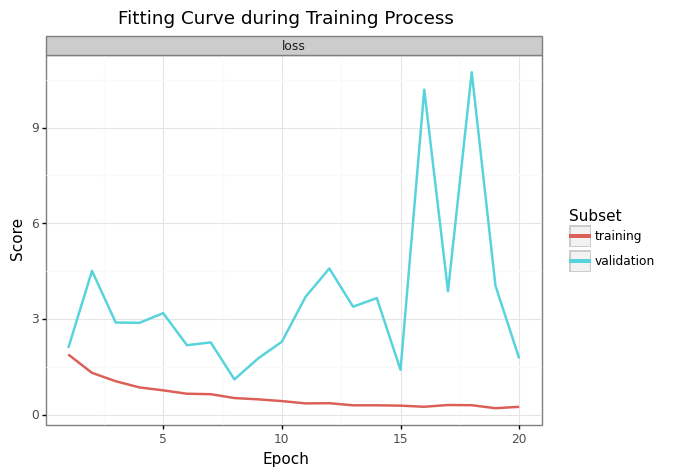

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


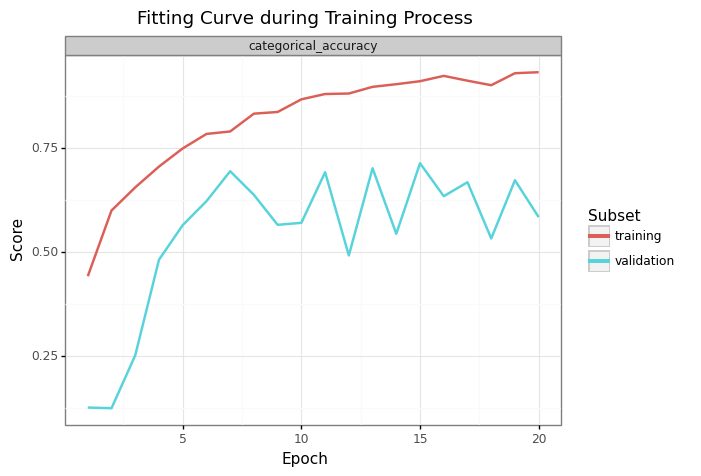

In [5]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="validation",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

It looks like some overfitting occured. We'll look at a possiblities how to deal with that in other notebooks (have a look at the notebooks about EarlyStopping or DataAugmentation, if you are interested).